In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Modelling Sub-halo Alignment 2-point Correlations

In [2]:
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar', redshift=0.0, dz_tol=0.001, version_name='halotools_v0p4')
for name in halocat.halo_table.dtype.names:
    print(name)

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


halo_vmax_firstacc
halo_dmvir_dt_tdyn
halo_macc
halo_scale_factor
halo_vmax_mpeak
halo_m_pe_behroozi
halo_xoff
halo_spin
halo_scale_factor_firstacc
halo_c_to_a
halo_mvir_firstacc
halo_scale_factor_last_mm
halo_scale_factor_mpeak
halo_pid
halo_m500c
halo_id
halo_halfmass_scale_factor
halo_upid
halo_t_by_u
halo_rvir
halo_vpeak
halo_dmvir_dt_100myr
halo_mpeak
halo_m_pe_diemer
halo_jx
halo_jy
halo_jz
halo_m2500c
halo_mvir
halo_voff
halo_axisA_z
halo_axisA_x
halo_axisA_y
halo_y
halo_b_to_a
halo_x
halo_z
halo_m200b
halo_vacc
halo_scale_factor_lastacc
halo_vmax
halo_m200c
halo_vx
halo_vy
halo_vz
halo_dmvir_dt_inst
halo_rs
halo_nfw_conc
halo_hostid
halo_mvir_host_halo


## Alignment Models

In [3]:
from intrinsic_alignments.ia_models.ia_model_components import CentralAlignment
from intrinsic_alignments.ia_models.ia_model_components import RadialSatelliteAlignment
from intrinsic_alignments.ia_models.ia_model_components import MajorAxisSatelliteAlignment
from intrinsic_alignments.ia_models.ia_model_components import HybridSatelliteAlignment
from intrinsic_alignments.ia_models.ia_model_components import RadialSatelliteAlignmentStrength

In [4]:
# create a model table
from intrinsic_alignments.ia_models.utils import halocat_to_galaxy_table
table = halocat_to_galaxy_table(halocat)

In [5]:
# apply central alignments to model
cen_alignment_model = CentralAlignment(central_alignment_stregth=0.99)
table = cen_alignment_model.assign_central_orientation(table=table)

/Users/duncan/Code/halotools/halotools/utils/matrix_operations_3d.py:88: RuntimeWarning: invalid value encountered in true_divide
  return vectors/elementwise_norm(vectors).reshape((npts, -1))
/Users/duncan/Code/halotools/halotools/utils/matrix_operations_3d.py:130: RuntimeWarning: invalid value encountered in greater
  mask1 = (dot > 1) & (dot < 1 + tol)
/Users/duncan/Code/halotools/halotools/utils/matrix_operations_3d.py:130: RuntimeWarning: invalid value encountered in less
  mask1 = (dot > 1) & (dot < 1 + tol)
/Users/duncan/Code/halotools/halotools/utils/matrix_operations_3d.py:132: RuntimeWarning: invalid value encountered in less
  mask2 = (dot < -1) & (dot > -1 - tol)
/Users/duncan/Code/halotools/halotools/utils/matrix_operations_3d.py:132: RuntimeWarning: invalid value encountered in greater
  mask2 = (dot < -1) & (dot > -1 - tol)


/Users/duncan/Projects/intrinsic_alignments/ia_models/ia_model_components.py:549: RuntimeWarning: divide by zero encountered in true_divide
  r = np.sqrt(dx**2 + dy**2 + dz**2)/halo_r
/Users/duncan/Projects/intrinsic_alignments/ia_models/ia_model_components.py:576: RuntimeWarning: divide by zero encountered in true_divide
  result = a*(1.0-1.0/(1.0+(1.0/r)**gamma))


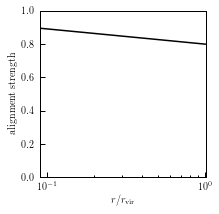

In [6]:
# apply satellite alignments to model
sat_alignment_strength = RadialSatelliteAlignmentStrength(satellite_alignment_a=1.6, satellite_alignment_gamma=0.1)
sat_alignment_model = RadialSatelliteAlignment(Lbox=halocat.Lbox)
table = sat_alignment_strength.assign_satellite_alignment_strength(table=table, Lbox=halocat.Lbox)
table = sat_alignment_model.assign_orientation(table=table)

r_sample = np.logspace(-2,0,100)
fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
plt.plot(r_sample, sat_alignment_strength.alignment_strength_radial_dependence(r_sample), '-', color='black')
plt.ylim([0,1])
plt.xlim([0.09,1.01])
plt.xscale('log')
plt.ylabel('alignment strength')
plt.xlabel(r'$r/r_{\rm vir}$')
plt.show()

filename = "radial_subhalo_alignment_strength.pdf"
fig.savefig('/Users/duncan/Projects/intrinsic_alignments/halo_shape_correlations/figures/'+filename, dpi=250)

## Alignment Correlation Functions

In [7]:
from halotools.mock_observables.alignments import ed_3d, ee_3d
from halotools.mock_observables.alignments import ee_3d_one_two_halo_decomp, ed_3d_one_two_halo_decomp

rbins = np.logspace(-1,1.4,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

In [8]:
# galaxy coordinates and orientations
galaxy_coords = np.vstack((table['x'],
                           table['y'],
                           table['z'])).T

galaxy_orientations = np.vstack((table['galaxy_axisA_x'],
                                 table['galaxy_axisA_y'],
                                 table['galaxy_axisA_z'])).T

cens = table['gal_type']=='centrals'
sats = table['gal_type']=='satellites'
gal_mask = table['halo_mpeak']>10**12.0

# halo orientations
halo_coords = np.vstack((halocat.halo_table['halo_x'],
                         halocat.halo_table['halo_y'],
                         halocat.halo_table['halo_z'])).T

halo_orientations = np.vstack((halocat.halo_table['halo_axisA_x'],
                               halocat.halo_table['halo_axisA_y'],
                               halocat.halo_table['halo_axisA_z'])).T

hosts = halocat.halo_table['halo_upid']==-1
subs = halocat.halo_table['halo_upid']!=-1
halo_mask = halocat.halo_table['halo_mpeak']>10**12.0

In [9]:
galaxy_eta = ed_3d(galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                   galaxy_coords[gal_mask],
                   rbins, period=halocat.Lbox, num_threads=1)
galaxy_omega = ee_3d(galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                     galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                     rbins, period=halocat.Lbox, num_threads=1)

In [10]:
halo_eta = ed_3d(halo_coords[halo_mask], halo_orientations[halo_mask], halo_coords[halo_mask],
                 rbins, period=halocat.Lbox, num_threads=4)
halo_omega = ee_3d(halo_coords[halo_mask], halo_orientations[halo_mask],
                   halo_coords[halo_mask], halo_orientations[halo_mask],
                   rbins, period=halocat.Lbox, num_threads=4)

## 1- and 2-halo decomposition

In [11]:
host_ids = table['halo_hostid']

galaxy_eta_1h, galaxy_eta_2h  = ed_3d_one_two_halo_decomp(galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                          host_ids[gal_mask],
                                                          galaxy_coords[gal_mask], host_ids[gal_mask],
                                                          rbins, period=halocat.Lbox, num_threads=4)
galaxy_omega_1h, galaxy_omega_2h = ee_3d_one_two_halo_decomp(galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                             host_ids[gal_mask],
                                                             galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                             host_ids[gal_mask],
                                                             rbins, period=halocat.Lbox, num_threads=4)

In [12]:
galaxy_eta_1h, galaxy_eta_2h  = ed_3d_one_two_halo_decomp(galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                          host_ids[gal_mask],
                                                          galaxy_coords[gal_mask], host_ids[gal_mask],
                                                          rbins, period=halocat.Lbox, num_threads=4)
galaxy_omega_1h, galaxy_omega_2h = ee_3d_one_two_halo_decomp(galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                             host_ids[gal_mask],
                                                             galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                             host_ids[gal_mask],
                                                             rbins, period=halocat.Lbox, num_threads=4)

In [13]:
host_ids = halocat.halo_table['halo_hostid']
halo_eta_1h, halo_eta_2h = ed_3d_one_two_halo_decomp(halo_coords[halo_mask], halo_orientations[halo_mask],
                                                     host_ids[halo_mask],
                                                     halo_coords[halo_mask], host_ids[halo_mask],
                                                     rbins, period=halocat.Lbox, num_threads=4)
halo_omega_1h, halo_omega_2h= ee_3d_one_two_halo_decomp(halo_coords[halo_mask], halo_orientations[halo_mask],
                                                        host_ids[halo_mask],
                                                        halo_coords[halo_mask], halo_orientations[halo_mask],
                                                        host_ids[halo_mask],
                                                        rbins, period=halocat.Lbox, num_threads=4)

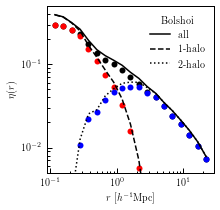

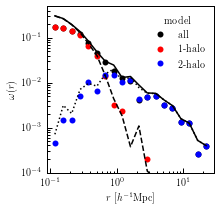

In [14]:
fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
p1, = plt.plot(rbin_centers, galaxy_eta, 'o', color='black', mec='none')
p1, = plt.plot(rbin_centers, galaxy_eta_1h, 'o', color='red', mec='none')
p1, = plt.plot(rbin_centers, galaxy_eta_2h, 'o', color='blue', mec='none')
l1, = plt.plot(rbin_centers, halo_eta, '-', color='black')
l2, = plt.plot(rbin_centers, halo_eta_1h, '--', color='black')
l3, = plt.plot(rbin_centers, halo_eta_2h, ':', color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}\rm Mpc]$')
plt.ylabel(r'$\eta(r)$')
plt.ylim([0.005,0.5])
plt.legend([l1,l2,l3],['all', '1-halo', '2-halo'], frameon=False, loc='upper right', fontsize=10, title='Bolshoi')
plt.show()

filename = "subhalo_ed_tpcf.pdf"
fig.savefig('/Users/duncan/Projects/intrinsic_alignments/halo_shape_correlations/figures/'+filename, dpi=250)

fig, ax  = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
p1, = plt.plot(rbin_centers, galaxy_omega, 'o', color='black', mec='none')
p2, = plt.plot(rbin_centers, galaxy_omega_1h, 'o', color='red', mec='none')
p3, = plt.plot(rbin_centers, galaxy_omega_2h, 'o', color='blue', mec='none')
l1, = plt.plot(rbin_centers, halo_omega, '-', color='black')
l2, = plt.plot(rbin_centers, halo_omega_1h, '--', color='black')
l3, = plt.plot(rbin_centers, halo_omega_2h, ':', color='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}\rm Mpc]$')
plt.ylabel(r'$\omega(r)$')
plt.ylim([0.0001,0.5])
plt.legend([p1,p2,p3],['all', '1-halo', '2-halo'], frameon=False, loc='upper right', fontsize=10, title='model')
plt.show()

filename = "subhalo_ee_tpcf.pdf"
fig.savefig('/Users/duncan/Projects/intrinsic_alignments/halo_shape_correlations/figures/'+filename, dpi=250)

## further decomposition

In [15]:
# (sub-)haloes

centrals = (halocat.halo_table['halo_upid'][halo_mask]==-1)
satellites = (halocat.halo_table['halo_upid'][halo_mask]!=-1)

host_ids = halocat.halo_table['halo_hostid']

In [21]:
# EE
halo_omega_1h_ss, halo_omega_2h_ss = ee_3d_one_two_halo_decomp(halo_coords[halo_mask], halo_orientations[halo_mask],
                                                        host_ids[halo_mask],
                                                        halo_coords[halo_mask], halo_orientations[halo_mask],
                                                        host_ids[halo_mask],rbins, 
                                                        mask1 = satellites,  
                                                        mask2 = satellites,
                                                        period=halocat.Lbox, num_threads=4)

In [22]:
halo_omega_1h_cs, halo_omega_2h_cs = ee_3d_one_two_halo_decomp(halo_coords[halo_mask], halo_orientations[halo_mask],
                                                        host_ids[halo_mask],
                                                        halo_coords[halo_mask], halo_orientations[halo_mask],
                                                        host_ids[halo_mask],rbins, 
                                                        mask1 = centrals,  
                                                        mask2 = satellites,
                                                        period=halocat.Lbox, num_threads=4)

In [23]:
halo_omega_1h_sc, halo_omega_2h_sc = ee_3d_one_two_halo_decomp(halo_coords[halo_mask], halo_orientations[halo_mask],
                                                        host_ids[halo_mask],
                                                        halo_coords[halo_mask], halo_orientations[halo_mask],
                                                        host_ids[halo_mask],rbins, 
                                                        mask1 = satellites,  
                                                        mask2 = centrals,
                                                        period=halocat.Lbox, num_threads=4)

In [24]:
halo_omega_1h_cc, halo_omega_2h_cc = ee_3d_one_two_halo_decomp(halo_coords[halo_mask], halo_orientations[halo_mask],
                                                        host_ids[halo_mask],
                                                        halo_coords[halo_mask], halo_orientations[halo_mask],
                                                        host_ids[halo_mask],rbins, 
                                                        mask1 = centrals,  
                                                        mask2 = centrals,
                                                        period=halocat.Lbox, num_threads=4)

In [25]:
## ED
halo_eta_1h_ss, halo_eta_2h_ss = ed_3d_one_two_halo_decomp(halo_coords[halo_mask], halo_orientations[halo_mask],
                                    host_ids[halo_mask],
                                    halo_coords[halo_mask], host_ids[halo_mask],
                                    rbins,
                                    mask1 = satellites,  
                                    mask2 = satellites,
                                    period=halocat.Lbox, num_threads=4)

In [26]:
halo_eta_1h_cs, halo_eta_2h_cs = ed_3d_one_two_halo_decomp(halo_coords[halo_mask], halo_orientations[halo_mask],
                                    host_ids[halo_mask],
                                    halo_coords[halo_mask], host_ids[halo_mask],
                                    rbins,
                                    mask1 = centrals,  
                                    mask2 = satellites,
                                    period=halocat.Lbox, num_threads=4)

In [27]:
halo_eta_1h_sc, halo_eta_2h_sc = ed_3d_one_two_halo_decomp(halo_coords[halo_mask], halo_orientations[halo_mask],
                                    host_ids[halo_mask],
                                    halo_coords[halo_mask], host_ids[halo_mask],
                                    rbins,
                                    mask1 = satellites,  
                                    mask2 = centrals,
                                    period=halocat.Lbox, num_threads=4)

In [28]:
halo_eta_1h_cc, halo_eta_2h_cc = ed_3d_one_two_halo_decomp(halo_coords[halo_mask], halo_orientations[halo_mask],
                                    host_ids[halo_mask],
                                    halo_coords[halo_mask], host_ids[halo_mask],
                                    rbins,
                                    mask1 = centrals,  
                                    mask2 = centrals,
                                    period=halocat.Lbox, num_threads=4)

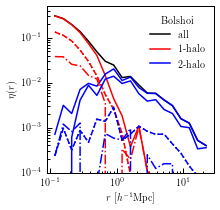

In [89]:
## plot EE results

fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
l1, = plt.plot(rbin_centers, halo_omega, '-', color='black')
l2, = plt.plot(rbin_centers, halo_omega_1h, '-', color='red')
l3, = plt.plot(rbin_centers, halo_omega_2h, '-', color='blue')
l4, = plt.plot(rbin_centers, halo_omega_1h_cc, '-', color='red')
l5, = plt.plot(rbin_centers, halo_omega_1h_sc, '--', color='red')
l6, = plt.plot(rbin_centers, halo_omega_1h_cs, ':', color='red')
l7, = plt.plot(rbin_centers, halo_omega_1h_ss, '-.', color='red')
l8, = plt.plot(rbin_centers, halo_omega_2h_cc, '-', color='blue')
l9, = plt.plot(rbin_centers, halo_omega_2h_sc, '--', color='blue')
l10, = plt.plot(rbin_centers, halo_omega_2h_cs, ':', color='blue')
l11, = plt.plot(rbin_centers, halo_omega_2h_ss, '-.', color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}\rm Mpc]$')
plt.ylabel(r'$\eta(r)$')
plt.ylim([0.0001,0.5])
plt.legend([l1,l2,l3],['all', '1-halo', '2-halo'], frameon=False, loc='upper right', fontsize=10, title='Bolshoi')
plt.show()

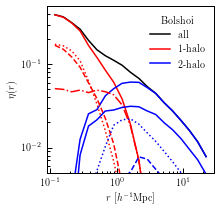

In [90]:
# plot ED results

fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
l1, = plt.plot(rbin_centers, halo_eta, '-', color='black')
l2, = plt.plot(rbin_centers, halo_eta_1h, '-', color='red')
l3, = plt.plot(rbin_centers, halo_eta_2h, '-', color='blue')
l4, = plt.plot(rbin_centers, halo_eta_1h_cc, '-', color='red')
l5, = plt.plot(rbin_centers, halo_eta_1h_sc, '--', color='red')
l6, = plt.plot(rbin_centers, halo_eta_1h_cs, ':', color='red')
l7, = plt.plot(rbin_centers, halo_eta_1h_ss, '-.', color='red')
l8, = plt.plot(rbin_centers, halo_eta_2h_cc, '-', color='blue')
l9, = plt.plot(rbin_centers, halo_eta_2h_sc, '--', color='blue')
l10, = plt.plot(rbin_centers, halo_eta_2h_cs, ':', color='blue')
l11, = plt.plot(rbin_centers, halo_eta_2h_ss, '-.', color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}\rm Mpc]$')
plt.ylabel(r'$\eta(r)$')
plt.ylim([0.005,0.5])
plt.legend([l1,l2,l3],['all', '1-halo', '2-halo'], frameon=False, loc='upper right', fontsize=10, title='Bolshoi')
plt.show()

In [91]:
# galaxies

host_ids = table['halo_hostid']
satellites = table['gal_type'][gal_mask]=='satellites'
centrals = table['gal_type'][gal_mask]=='centrals'

In [92]:
# EE
galaxy_omega_1h_cc, galaxy_omega_2h_cc = ee_3d_one_two_halo_decomp(galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                             host_ids[gal_mask],
                                                             galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                             host_ids[gal_mask],
                                                             rbins,
                                                             mask1 = centrals, mask2 = centrals,
                                                             period=halocat.Lbox, num_threads=4)

In [93]:
galaxy_omega_1h_sc, galaxy_omega_2h_sc = ee_3d_one_two_halo_decomp(galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                             host_ids[gal_mask],
                                                             galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                             host_ids[gal_mask],
                                                             rbins,
                                                             mask1 = satellites, mask2 = centrals,
                                                             period=halocat.Lbox, num_threads=4)

In [94]:
galaxy_omega_1h_cs, galaxy_omega_2h_cs = ee_3d_one_two_halo_decomp(galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                             host_ids[gal_mask],
                                                             galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                             host_ids[gal_mask],
                                                             rbins,
                                                             mask1 = centrals, mask2 = satellites,
                                                             period=halocat.Lbox, num_threads=4)

In [95]:
galaxy_omega_1h_ss, galaxy_omega_2h_ss = ee_3d_one_two_halo_decomp(galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                             host_ids[gal_mask],
                                                             galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                             host_ids[gal_mask],
                                                             rbins,
                                                             mask1 = satellites, mask2 = satellites,
                                                             period=halocat.Lbox, num_threads=4)

In [ ]:
# ED
galaxy_eta_1h_cc, galaxy_eta_2h_cc  = ed_3d_one_two_halo_decomp(galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                          host_ids[gal_mask],
                                                          galaxy_coords[gal_mask], host_ids[gal_mask],
                                                          rbins,
                                                          mask1 = centrals, mask2 = centrals,
                                                          period=halocat.Lbox, num_threads=4)

In [ ]:
galaxy_eta_1h_sc, galaxy_eta_2h_sc  = ed_3d_one_two_halo_decomp(galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                          host_ids[gal_mask],
                                                          galaxy_coords[gal_mask], host_ids[gal_mask],
                                                          rbins,
                                                          mask1 = satellites, mask2 = centrals,
                                                          period=halocat.Lbox, num_threads=4)

In [ ]:
galaxy_eta_1h_cs, galaxy_eta_2h_cs  = ed_3d_one_two_halo_decomp(galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                          host_ids[gal_mask],
                                                          galaxy_coords[gal_mask], host_ids[gal_mask],
                                                          rbins,
                                                          mask1 = centrals, mask2 = satellites,
                                                          period=halocat.Lbox, num_threads=4)

In [ ]:
galaxy_eta_1h_ss, galaxy_eta_2h_ss  = ed_3d_one_two_halo_decomp(galaxy_coords[gal_mask], galaxy_orientations[gal_mask],
                                                          host_ids[gal_mask],
                                                          galaxy_coords[gal_mask], host_ids[gal_mask],
                                                          rbins,
                                                          mask1 = satellites, mask2 = satellites,
                                                          period=halocat.Lbox, num_threads=4)

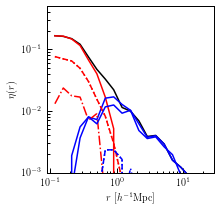

In [97]:
# plot EE results

fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
l1, = plt.plot(rbin_centers, galaxy_omega, '-', color='black')
l2, = plt.plot(rbin_centers, galaxy_omega_1h, '-', color='red')
l3, = plt.plot(rbin_centers, galaxy_omega_2h, '-', color='blue')
l4, = plt.plot(rbin_centers, galaxy_omega_1h_cc, '-', color='red')
l5, = plt.plot(rbin_centers, galaxy_omega_1h_sc, '--', color='red')
l6, = plt.plot(rbin_centers, galaxy_omega_1h_cs, ':', color='red')
l7, = plt.plot(rbin_centers, galaxy_omega_1h_ss, '-.', color='red')
l8, = plt.plot(rbin_centers, galaxy_omega_2h_cc, '-', color='blue')
l9, = plt.plot(rbin_centers, galaxy_omega_2h_sc, '--', color='blue')
l10, = plt.plot(rbin_centers, galaxy_omega_2h_cs, ':', color='blue')
l11, = plt.plot(rbin_centers, galaxy_omega_2h_ss, '-.', color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}\rm Mpc]$')
plt.ylabel(r'$\eta(r)$')
plt.ylim([0.001,0.5])
plt.show()

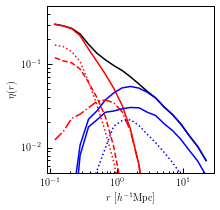

In [96]:
#plot ED results

fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
l1, = plt.plot(rbin_centers, galaxy_eta, '-', color='black')
l2, = plt.plot(rbin_centers, galaxy_eta_1h, '-', color='red')
l3, = plt.plot(rbin_centers, galaxy_eta_2h, '-', color='blue')
l4, = plt.plot(rbin_centers, galaxy_eta_1h_cc, '-', color='red')
l5, = plt.plot(rbin_centers, galaxy_eta_1h_sc, '--', color='red')
l6, = plt.plot(rbin_centers, galaxy_eta_1h_cs, ':', color='red')
l7, = plt.plot(rbin_centers, galaxy_eta_1h_ss, '-.', color='red')
l8, = plt.plot(rbin_centers, galaxy_eta_2h_cc, '-', color='blue')
l9, = plt.plot(rbin_centers, galaxy_eta_2h_sc, '--', color='blue')
l10, = plt.plot(rbin_centers, galaxy_eta_2h_cs, ':', color='blue')
l11, = plt.plot(rbin_centers, galaxy_eta_2h_ss, '-.', color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}\rm Mpc]$')
plt.ylabel(r'$\eta(r)$')
plt.ylim([0.005,0.5])
plt.show()

In [31]:
# all together now

fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
l1, = plt.plot(rbin_centers, galaxy_omega, '-', color='black')
l2, = plt.plot(rbin_centers, galaxy_omega_1h, '-', color='red')
l3, = plt.plot(rbin_centers, galaxy_omega_2h, '-', color='blue')
l4, = plt.plot(rbin_centers, galaxy_omega_1h_cc, '-', color='red')
l5, = plt.plot(rbin_centers, galaxy_omega_1h_sc, '--', color='red')
l6, = plt.plot(rbin_centers, galaxy_omega_1h_cs, ':', color='red')
l7, = plt.plot(rbin_centers, galaxy_omega_1h_ss, '-.', color='red')
l8, = plt.plot(rbin_centers, galaxy_omega_2h_cc, '-', color='blue')
l9, = plt.plot(rbin_centers, galaxy_omega_2h_sc, '--', color='blue')
l10, = plt.plot(rbin_centers, galaxy_omega_2h_cs, ':', color='blue')
l11, = plt.plot(rbin_centers, galaxy_omega_2h_ss, '-.', color='blue')
l1, = plt.plot(rbin_centers, galaxy_omega, 'o', color='black')
l2, = plt.plot(rbin_centers, galaxy_omega_1h, 'o', color='red')
l3, = plt.plot(rbin_centers, galaxy_omega_2h, 'o', color='blue')
l4, = plt.plot(rbin_centers, galaxy_omega_1h_cc, 'o', color='red')
l5, = plt.plot(rbin_centers, galaxy_omega_1h_sc, 'o', color='red')
l6, = plt.plot(rbin_centers, galaxy_omega_1h_cs, 'o', color='red')
l7, = plt.plot(rbin_centers, galaxy_omega_1h_ss, 'o', color='red')
l8, = plt.plot(rbin_centers, galaxy_omega_2h_cc, 'o', color='blue')
l9, = plt.plot(rbin_centers, galaxy_omega_2h_sc, 'o', color='blue')
l10, = plt.plot(rbin_centers, galaxy_omega_2h_cs, 'o', color='blue')
l11, = plt.plot(rbin_centers, galaxy_omega_2h_ss, 'o', color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}\rm Mpc]$')
plt.ylabel(r'$\eta(r)$')
plt.ylim([0.001,0.5])
plt.show()

fig, ax = plt.subplots(figsize=(3.3,3.3))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
l1, = plt.plot(rbin_centers, halo_eta, '-', color='black')
l2, = plt.plot(rbin_centers, halo_eta_1h, '-', color='red')
l3, = plt.plot(rbin_centers, halo_eta_2h, '-', color='blue')
l4, = plt.plot(rbin_centers, halo_eta_1h_cc, '-', color='red')
l5, = plt.plot(rbin_centers, halo_eta_1h_sc, '--', color='red')
l6, = plt.plot(rbin_centers, halo_eta_1h_cs, ':', color='red')
l7, = plt.plot(rbin_centers, halo_eta_1h_ss, '-.', color='red')
l8, = plt.plot(rbin_centers, halo_eta_2h_cc, '-', color='blue')
l9, = plt.plot(rbin_centers, halo_eta_2h_sc, '--', color='blue')
l10, = plt.plot(rbin_centers, halo_eta_2h_cs, ':', color='blue')
l11, = plt.plot(rbin_centers, halo_eta_2h_ss, '-.', color='blue')
l1, = plt.plot(rbin_centers, galaxy_eta, 'o', color='black')
l2, = plt.plot(rbin_centers, galaxy_eta_1h, 'o, color='red')
l3, = plt.plot(rbin_centers, galaxy_eta_2h, 'o', color='blue')
l4, = plt.plot(rbin_centers, galaxy_eta_1h_cc, 'o', color='red')
l5, = plt.plot(rbin_centers, galaxy_eta_1h_sc, 'o', color='red')
l6, = plt.plot(rbin_centers, galaxy_eta_1h_cs, 'o', color='red')
l7, = plt.plot(rbin_centers, galaxy_eta_1h_ss, 'o', color='red')
l8, = plt.plot(rbin_centers, galaxy_eta_2h_cc, 'o', color='blue')
l9, = plt.plot(rbin_centers, galaxy_eta_2h_sc, 'o', color='blue')
l10, = plt.plot(rbin_centers, galaxy_eta_2h_cs, 'o', color='blue')
l11, = plt.plot(rbin_centers, galaxy_eta_2h_ss, 'o', color='blue')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r~[h^{-1}\rm Mpc]$')
plt.ylabel(r'$\eta(r)$')
plt.ylim([0.005,0.5])
plt.show()

SyntaxError: invalid syntax (<ipython-input-31-d89928884e91>, line 48)